In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

# Load dataset
df = pd.read_csv("electricity_cost_dataset.csv")
df.head()


,site area,structure type,water consumption,recycling rate,utilisation rate,air qality index,issue reolution time,resident count,electricity cost
0,1360,Mixed-use,2519.0,69,52,188,1,72,1420.0
1,4272,Mixed-use,2324.0,50,76,165,65,261,3298.0
2,3592,Mixed-use,2701.0,20,94,198,39,117,3115.0
3,966,Residential,1000.0,13,60,74,3,35,1575.0
4,4926,Residential,5990.0,23,65,32,57,185,4301.0


In [ ]:
# Replace common NA representations
df.replace(['?', 'NaN', 'nan', 'null', 'NULL', 'NA', 'na', ''], np.nan, inplace=True)
print(df.isnull().sum())

# Fill numeric NA by median, categorical by mode
for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].median(), inplace=True)
for col in df.select_dtypes(include=object).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

df.head()


site area               0
structure type          0
water consumption       0
recycling rate          0
utilisation rate        0
air qality index        0
issue reolution time    0
resident count          0
electricity cost        0
dtype: int64


/tmp/ipython-input-2342809179.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-2342809179.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

,site area,structure type,water consumption,recycling rate,utilisation rate,air qality index,issue reolution time,resident count,electricity cost
0,1360,Mixed-use,2519.0,69,52,188,1,72,1420.0
1,4272,Mixed-use,2324.0,50,76,165,65,261,3298.0
2,3592,Mixed-use,2701.0,20,94,198,39,117,3115.0
3,966,Residential,1000.0,13,60,74,3,35,1575.0
4,4926,Residential,5990.0,23,65,32,57,185,4301.0


In [ ]:
# Convert Datetime columns if present
for col in df.columns:
    if 'date' in col.lower() or 'time' in col.lower():
        df[col] = pd.to_datetime(df[col], errors='coerce')


In [ ]:
for col in df.select_dtypes(include=object).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
df.head()


,site area,structure type,water consumption,recycling rate,utilisation rate,air qality index,issue reolution time,resident count,electricity cost
0,1360,2,2519.0,69,52,188,1970-01-01 00:00:00.000000001,72,1420.0
1,4272,2,2324.0,50,76,165,1970-01-01 00:00:00.000000065,261,3298.0
2,3592,2,2701.0,20,94,198,1970-01-01 00:00:00.000000039,117,3115.0
3,966,3,1000.0,13,60,74,1970-01-01 00:00:00.000000003,35,1575.0
4,4926,3,5990.0,23,65,32,1970-01-01 00:00:00.000000057,185,4301.0


In [ ]:
scaler = MinMaxScaler()
df_norm = df.copy()
df_norm[df_norm.select_dtypes(include=np.number).columns] = scaler.fit_transform(df_norm.select_dtypes(include=np.number))

stdscaler = StandardScaler()
df_std = df.copy()
df_std[df_std.select_dtypes(include=np.number).columns] = stdscaler.fit_transform(df_std.select_dtypes(include=np.number))

print("Normalization and Standardization done.")


Normalization and Standardization done.


In [ ]:
print("Before removing duplicates:", df.shape)
df = df.drop_duplicates()
print("After removing duplicates:", df.shape)


Before removing duplicates: (10000, 9)
After removing duplicates: (10000, 9)


In [ ]:
for col in df.select_dtypes(include=np.number).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])

print("Outliers treated.")


Outliers treated.


In [ ]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')


/tmp/ipython-input-3070116034.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


In [ ]:
numeric_df = df.select_dtypes(include=np.number)
selector = VarianceThreshold(threshold=0.01)
numeric_selected = numeric_df.loc[:, selector.fit(numeric_df).get_support()]


In [ ]:
corr_matrix = numeric_selected.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
numeric_selected = numeric_selected.drop(columns=to_drop, errors='ignore')
df_selected = pd.concat([numeric_selected, df.select_dtypes(exclude=np.number)], axis=1)

print("Feature selection done. Final shape:", df_selected.shape)


Feature selection done. Final shape: (10000, 9)


In [ ]:
X = df_selected.drop(columns=['electricity cost'])
y = df_selected['electricity cost']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (8000, 8)
Testing set shape: (2000, 8)


In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

print("Intercept:", lr.intercept_)
print("Number of coefficients:", len(lr.coef_))

y_pred = lr.predict(X_test)

# Performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

n = X_test.shape[0]  # Number of samples
p = X_test.shape[1]  # Number of features
adj_r2 = 1 - (1-r2) * (n-1) / (n-p-1)  # Adjusted R² formula

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R Score: {r2:.4f}")
print(f"Adjusted R Score: {adj_r2:.4f}")

# Create DataFrame for feature importance
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr.coef_})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False).reset_index(drop=True)

print(coef_df)


Intercept: 59.42265000774569
Number of coefficients: 8
Mean Squared Error (MSE): 235237.7350
Root Mean Squared Error (RMSE): 485.0131
Mean Absolute Error (MAE): 375.0039
R Score: 0.8114
Adjusted R Score: 0.8107
                Feature  Coefficient
0      utilisation rate    10.397218
1  issue reolution time     2.126752
2        resident count     0.816493
3             site area     0.652779
4      air qality index     0.472013
5     water consumption     0.057562
6        recycling rate    -0.506789
7        structure type   -37.009819


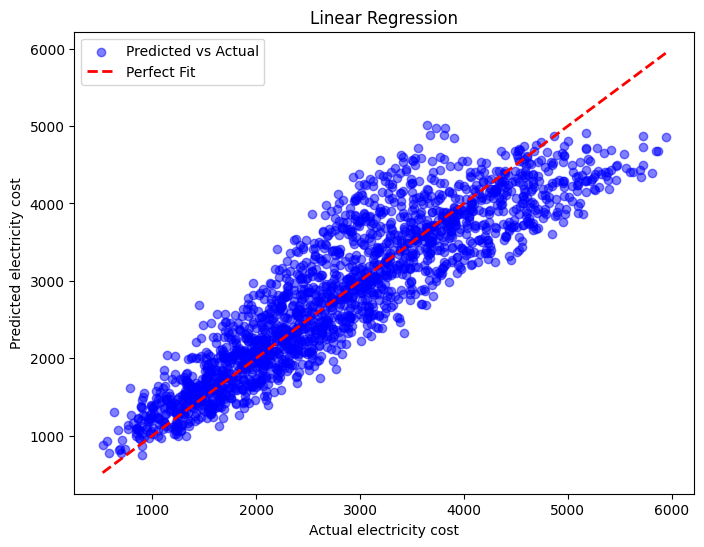

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Fit")
plt.xlabel("Actual electricity cost")
plt.ylabel("Predicted electricity cost")
plt.title("Linear Regression")
plt.legend()
plt.show()


In [ ]:
# Prepare data for CV with encoding
X_encoded = pd.get_dummies(X, drop_first=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2_scores = cross_val_score(lr, X_encoded, y, cv=kf, scoring='r2')
cv_mse_scores = cross_val_score(lr, X_encoded, y, cv=kf, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_mse_scores)
cv_mae_scores = cross_val_score(lr, X_encoded, y, cv=kf, scoring='neg_mean_absolute_error')

print("Cross-validation R2 scores:", cv_r2_scores)
print("Mean R2:", np.mean(cv_r2_scores))
print("Standard Deviation of R2:", np.std(cv_r2_scores))

print("Cross-validation RMSE scores:", cv_rmse_scores)
print("Mean RMSE:", np.mean(cv_rmse_scores))
print("Cross-validation MAE scores:", -cv_mae_scores)
print("Mean MAE:", -np.mean(cv_mae_scores))


Cross-validation R2 scores: [0.81143163 0.81313123 0.79976015 0.81425551 0.81209531]
Mean R2: 0.8101347650255768
Standard Deviation of R2: 0.0052748018252583555
Cross-validation RMSE scores: [485.01312869 478.32425664 488.39611972 475.64046533 483.19028476]
Mean RMSE: 482.11285102932015
Cross-validation MAE scores: [375.00394074 367.78902648 377.58217059 365.89542507 366.81690443]
Mean MAE: 370.617493461932


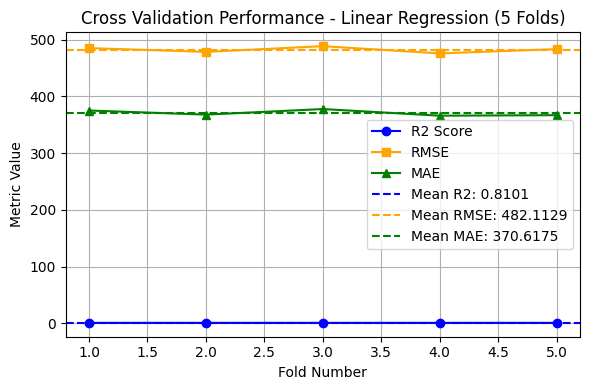

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 4))  # Reduced figure size

folds = range(1, len(cv_r2_scores) + 1)
plt.plot(folds, cv_r2_scores, marker='o', linestyle='-', color='blue', label='R2 Score')
plt.plot(folds, cv_rmse_scores, marker='s', linestyle='-', color='orange', label='RMSE')
plt.plot(folds, -cv_mae_scores, marker='^', linestyle='-', color='green', label='MAE')

plt.axhline(y=np.mean(cv_r2_scores), color='blue', linestyle='--', label=f"Mean R2: {np.mean(cv_r2_scores):.4f}")
plt.axhline(y=np.mean(cv_rmse_scores), color='orange', linestyle='--', label=f"Mean RMSE: {np.mean(cv_rmse_scores):.4f}")
plt.axhline(y=-np.mean(cv_mae_scores), color='green', linestyle='--', label=f"Mean MAE: {np.mean(-cv_mae_scores):.4f}")

plt.xlabel("Fold Number")
plt.ylabel("Metric Value")
plt.title("Cross Validation Performance - Linear Regression (5 Folds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


df = pd.read_csv("electricity_cost_dataset.csv")

X = df.drop(columns=['electricity cost'])
y = df['electricity cost']


cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

print("Columns after encoding:", X_encoded.columns)


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train multiple linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5  # Manual RMSE calculation for compatibility
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Adjusted R-squared calculation
n = len(y_test)  # Number of samples
p = X_test.shape[1]  # Number of features
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")
print(f"Adjusted R-squared: {adj_r2:.4f}")

# Coefficients as a DataFrame
coefficients = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Coefficient': lr.coef_
})

coefficients = coefficients.sort_values(by='Coefficient', ascending=False).reset_index(drop=True)
print(coefficients)


Columns after encoding: Index(['site area', 'water consumption', 'recycling rate', 'utilisation rate',
       'air qality index', 'issue reolution time', 'resident count',
       'structure type_Industrial', 'structure type_Mixed-use',
       'structure type_Residential'],
      dtype='object')
Mean Squared Error (MSE): 97381.9015
Root Mean Squared Error (RMSE): 312.0607
Mean Absolute Error (MAE): 245.6520
R-squared (R2): 0.9219
Adjusted R-squared: 0.9215
                      Feature  Coefficient
0   structure type_Industrial   599.351623
1            utilisation rate    10.254537
2              resident count     2.459711
3        issue reolution time     2.036999
4                   site area     0.614623
5            air qality index     0.500351
6           water consumption     0.052431
7              recycling rate    -0.926822
8  structure type_Residential  -189.822036
9    structure type_Mixed-use  -898.077698


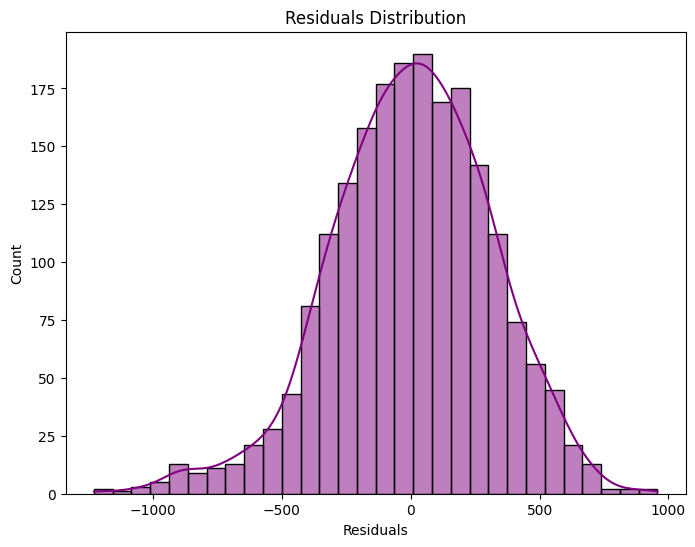

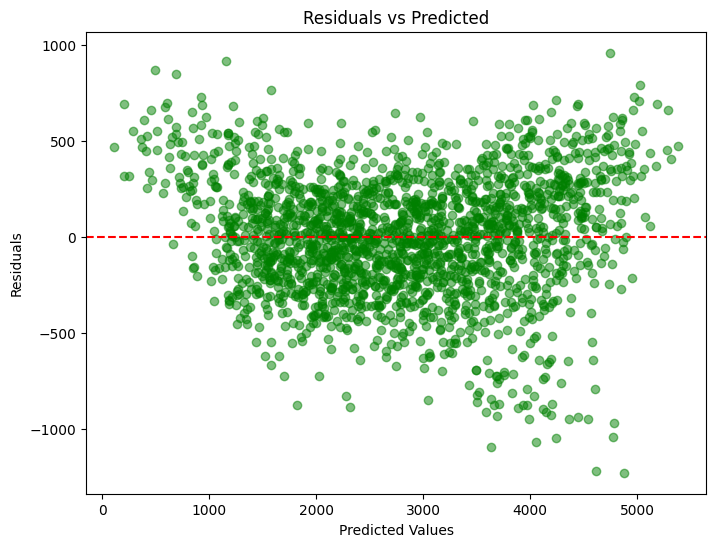

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.xlabel("Residuals")
plt.title("Residuals Distribution")
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.5, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()


In [ ]:
df['cost_category'] = pd.qcut(df['electricity cost'], q=3, labels=["Low", "Medium", "High"])
X_class = df.drop(columns=['electricity cost', 'cost_category'])
y_class = df['cost_category']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42, stratify=y_class)

print("Training set:", X_train_c.shape)
print("Testing set:", X_test_c.shape)


Training set: (8000, 8)
Testing set: (2000, 8)


In [ ]:
import pandas as pd

# Example, assuming X_train_c and X_test_c are DataFrames
X_train_c = pd.get_dummies(X_train_c)
X_test_c = pd.get_dummies(X_test_c)

# Align columns in case of any mismatch in categories between train and test
X_train_c, X_test_c = X_train_c.align(X_test_c, join='left', axis=1, fill_value=0)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_c, y_train_c)

print("Training Accuracy:", logreg.score(X_train_c, y_train_c))
print("Testing Accuracy:", logreg.score(X_test_c, y_test_c))


Training Accuracy: 0.750625
Testing Accuracy: 0.749


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
               precision    recall  f1-score   support

        High       0.75      0.83      0.79       666
         Low       0.83      0.85      0.84       667
      Medium       0.65      0.57      0.61       667

    accuracy                           0.75      2000
   macro avg       0.74      0.75      0.75      2000
weighted avg       0.74      0.75      0.75      2000



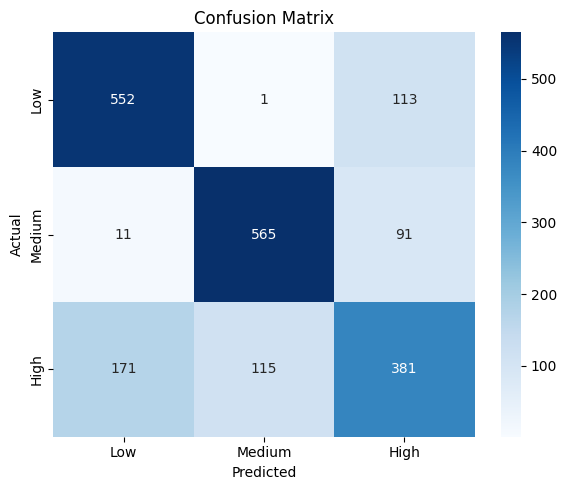

In [ ]:
y_pred_c = logreg.predict(X_test_c)

print("Classification Report:\n", classification_report(y_test_c, y_pred_c))

cm = confusion_matrix(y_test_c, y_pred_c)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


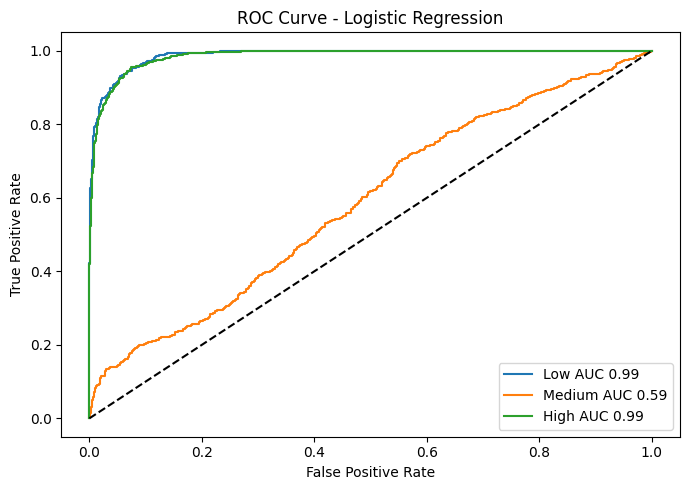

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

# Scale classification features
scaler = StandardScaler()
X_train_c_scaled = scaler.fit_transform(X_train_c)
X_test_c_scaled = scaler.transform(X_test_c)

# One-vs-Rest logistic regression
ovr = OneVsRestClassifier(LogisticRegression(max_iter=1000))
y_train_bin = label_binarize(y_train_c, classes=["Low", "Medium", "High"])
y_test_bin = label_binarize(y_test_c, classes=["Low", "Medium", "High"])

ovr.fit(X_train_c_scaled, y_train_bin)
y_score = ovr.decision_function(X_test_c_scaled)

classes = ["Low", "Medium", "High"]
plt.figure(figsize=(7,5))  # Reduced size for better display

for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} AUC {roc_auc:.2f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()


### ***PCA***

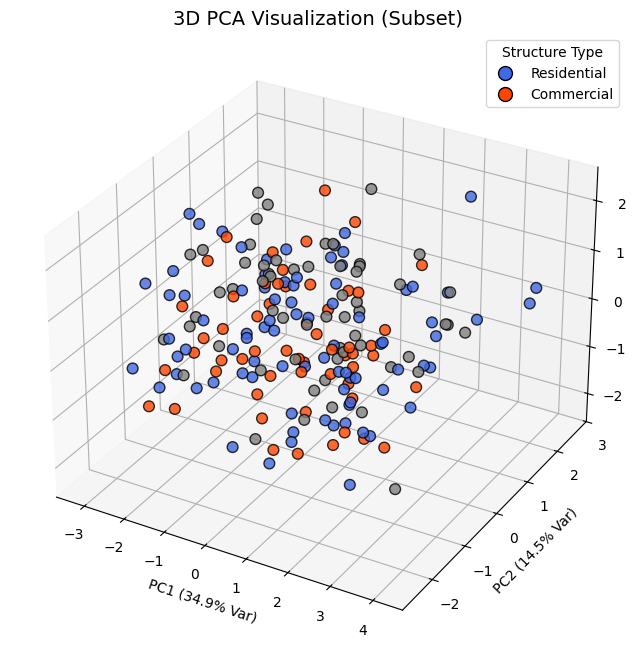

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load dataset
data = pd.read_csv('electricity_cost_dataset.csv')

# Take random subset, e.g. 200 rows
subset = data.sample(n=200, random_state=42)

# Select only numeric columns for PCA
numeric_cols = subset.select_dtypes(include=[np.number]).columns
numeric_data = subset[numeric_cols].copy()
numeric_data = numeric_data.fillna(numeric_data.mean())

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)


pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_data)
pcadf = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3'])

# Get colors from 'structure type' (do not include in PCA)
if 'structure type' in subset.columns:
    type_col = subset['structure type'].astype(str)
    main_types = type_col.value_counts().index[:2]
    mask1 = (type_col == main_types[0])
    mask2 = (type_col == main_types[1])
    colors = np.where(mask1, 'royalblue', np.where(mask2, 'orangered', 'gray'))
else:
    colors = 'royalblue'

# 3D PCA plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pcadf['PC1'], pcadf['PC2'], pcadf['PC3'], c=colors, s=60, alpha=0.8, edgecolor='k')
ax.set_title('3D PCA Visualization (Subset)', fontsize=14)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% Var)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% Var)')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}% Var)')
plt.legend(handles=[
    plt.Line2D([], [], marker='o', color='w', label=main_types[0], markerfacecolor='royalblue', markersize=10, markeredgecolor='k'),
    plt.Line2D([], [], marker='o', color='w', label=main_types[1], markerfacecolor='orangered', markersize=10, markeredgecolor='k')
], title='Structure Type')
plt.show()


## **NAIVE BAYES**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset and select a random subset
data = pd.read_csv('electricity_cost_dataset.csv')
subset = data.sample(n=200, random_state=42)


cat_cols = subset.select_dtypes(include=['object']).columns.tolist()
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    subset[col] = le.fit_transform(subset[col].astype(str))
    le_dict[col] = le

# Features and target
X = subset.drop('structure type', axis=1)
y = subset['structure type']

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Naïve Bayes
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.7
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.00      0.00      0.00         2
           2       0.80      0.40      0.53        10
           3       0.73      0.94      0.82        17

    accuracy                           0.70        40
   macro avg       0.58      0.52      0.53        40
weighted avg       0.73      0.70      0.69        40

Confusion matrix:
 [[ 8  3  0  0]
 [ 2  0  0  0]
 [ 0  0  4  6]
 [ 0  0  1 16]]


Dataset Loaded Successfully 

First five rows of dataset:


,site area,structure type,water consumption,recycling rate,utilisation rate,air qality index,issue reolution time,resident count,electricity cost
0,1360,Mixed-use,2519.0,69,52,188,1,72,1420.0
1,4272,Mixed-use,2324.0,50,76,165,65,261,3298.0
2,3592,Mixed-use,2701.0,20,94,198,39,117,3115.0
3,966,Residential,1000.0,13,60,74,3,35,1575.0
4,4926,Residential,5990.0,23,65,32,57,185,4301.0



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   site area             10000 non-null  int64  
 1   structure type        10000 non-null  object 
 2   water consumption     10000 non-null  float64
 3   recycling rate        10000 non-null  int64  
 4   utilisation rate      10000 non-null  int64  
 5   air qality index      10000 non-null  int64  
 6   issue reolution time  10000 non-null  int64  
 7   resident count        10000 non-null  int64  
 8   electricity cost      10000 non-null  float64
dtypes: float64(2), int64(6), object(1)
memory usage: 703.3+ KB
None

Categorical columns encoded successfully 


,site area,structure type,water consumption,recycling rate,utilisation rate,air qality index,issue reolution time,resident count,electricity cost
0,1360,2,2519.0,69,52,188,1,72,1420.0
1,4272,2,2324.0,50,76,165,65,261,3298.0
2,3592,2,2701.0,20,94,198,39,117,3115.0
3,966,3,1000.0,13,60,74,3,35,1575.0
4,4926,3,5990.0,23,65,32,57,185,4301.0



Training and Testing Split Completed.
Training Data Shape: (8000, 8)
Testing Data Shape: (2000, 8)

Naïve Bayes Model Trained Successfully 

Model Evaluation Results:
Accuracy of Naïve Bayes Classifier: 79.85%

Confusion Matrix:
[[101   0  89]
 [  0 758 101]
 [ 69 144 738]]

Classification Report:
              precision    recall  f1-score   support

        High       0.59      0.53      0.56       190
         Low       0.84      0.88      0.86       859
      Medium       0.80      0.78      0.79       951

    accuracy                           0.80      2000
   macro avg       0.74      0.73      0.74      2000
weighted avg       0.80      0.80      0.80      2000



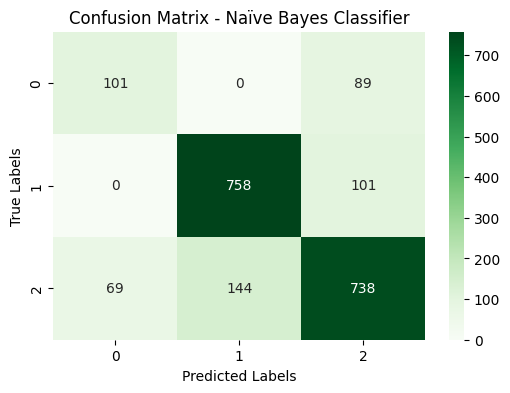

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Step 2: Load Dataset
data = pd.read_csv('/content/electricity_cost_dataset.csv')
print("Dataset Loaded Successfully ")
print("\nFirst five rows of dataset:")
display(data.head())

# Step 3: Dataset Information
print("\nDataset Information:")
print(data.info())

# Step 4: Encode Categorical Columns
label_encoders = {}
for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

print("\nCategorical columns encoded successfully ")
display(data.head())

# Step 5: Convert Target Variable to Categories
# We'll convert electricity cost into 3 categories (Low, Medium, High)
data['cost_category'] = pd.cut(
    data['electricity cost'],
    bins=3,
    labels=['Low', 'Medium', 'High']
)

# Step 6: Define Feature Matrix (X) and Target Vector (y)
X = data.drop(['electricity cost', 'cost_category'], axis=1)
y = data['cost_category']

# Step 7: Split Dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("\nTraining and Testing Split Completed.")
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")


nb_model = GaussianNB()


nb_model.fit(X_train, y_train)
print("\nNaïve Bayes Model Trained Successfully ")

# Step 10: Make Predictions
y_pred = nb_model.predict(X_test)

# Step 11: Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
print("\nModel Evaluation Results:")
print(f"Accuracy of Naïve Bayes Classifier: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 12: Visualization of Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Naïve Bayes Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




## **SVM**

Accuracy: 89.35%
              precision    recall  f1-score   support

        High       0.93      0.67      0.78       190
         Low       0.91      0.92      0.92       859
      Medium       0.87      0.91      0.89       951

    accuracy                           0.89      2000
   macro avg       0.91      0.84      0.86      2000
weighted avg       0.89      0.89      0.89      2000



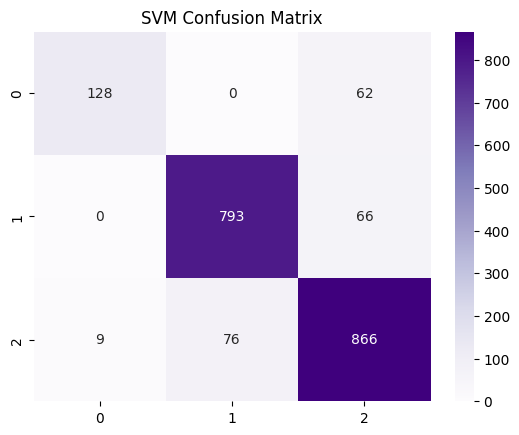

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


data = pd.read_csv('/content/electricity_cost_dataset.csv')
for col in data.select_dtypes(include=['object']).columns:
    data[col] = LabelEncoder().fit_transform(data[col])

# Create categorical target
data['cost_category'] = pd.cut(data['electricity cost'], bins=3, labels=['Low', 'Medium', 'High'])
X = data.drop(['electricity cost', 'cost_category'], axis=1)
y = data['cost_category']

# Split & scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)

# Train SVM
svm = SVC(kernel='rbf', C=1.0, gamma='scale')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title('SVM Confusion Matrix')
plt.show()



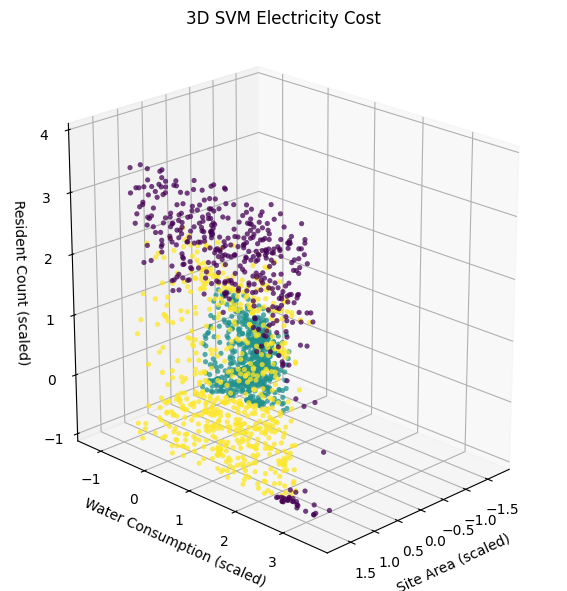

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --- Load & prep ---
df = pd.read_csv('/content/electricity_cost_dataset.csv')
for c in df.select_dtypes('object'):
    df[c] = LabelEncoder().fit_transform(df[c])
df['cost_category'] = pd.cut(df['electricity cost'], 3, labels=['Low','Medium','High'])
df = df.dropna(subset=['site area','water consumption','resident count','cost_category'])

X = df[['site area','water consumption','resident count']].to_numpy()
y = LabelEncoder().fit_transform(df['cost_category'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

# --- Train SVM ---
svm = SVC(kernel='rbf', gamma='scale')
svm.fit(X_train, y_train)

# --- Predict on TRAIN for coloring ---
y_pred = svm.predict(X_train)

# --- Stratified downsample to reduce clutter (NO slicing) ---
def stratified_sample(X, y, per_class=600, seed=0):
    rng = np.random.RandomState(seed)
    keep_idx = []
    for k in np.unique(y):
        idx_k = np.where(y == k)[0]
        n = min(per_class, len(idx_k))
        keep_idx.append(rng.choice(idx_k, n, replace=False))
    return np.concatenate(keep_idx)

keep = stratified_sample(X_train, y_pred, per_class=600)  # tweak 300–800 as you like

# --- Plot ---
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# smaller dots, lighter edges, a bit transparent
ax.scatter(
    X_train[keep,0], X_train[keep,1], X_train[keep,2],
    c=y_pred[keep], cmap='viridis',
    s=14, alpha=0.75, edgecolors='none', depthshade=True
)

ax.set_xlabel('Site Area (scaled)')
ax.set_ylabel('Water Consumption (scaled)')
ax.set_zlabel('Resident Count (scaled)')
ax.set_title('3D SVM Electricity Cost')

# nicer camera & aspect
ax.view_init(elev=22, azim=45)
rngs = X_train.max(axis=0) - X_train.min(axis=0)
ax.set_box_aspect(rngs / rngs.max())

plt.tight_layout()
plt.show()


**HIERARCHIAL** **CLUSTERING**


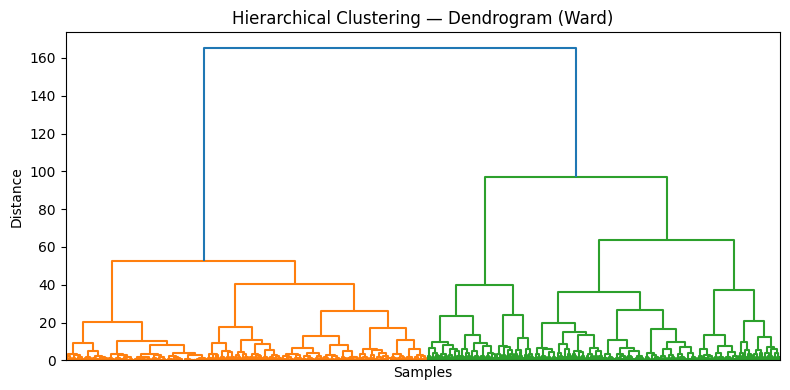

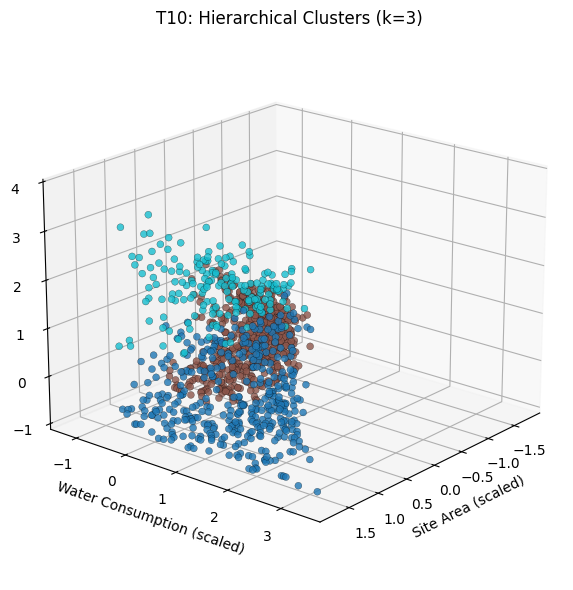

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, dendrogram

# ---------- Load and Prepare ----------
df = pd.read_csv('/content/electricity_cost_dataset.csv')
for c in df.select_dtypes('object'):
    df[c] = LabelEncoder().fit_transform(df[c])

df['cost_category'] = pd.cut(df['electricity cost'], 3, labels=['Low','Medium','High'])
df = df.dropna(subset=['site area','water consumption','resident count','cost_category'])

X = df[['site area','water consumption','resident count']].to_numpy(dtype=float)
sc = StandardScaler()
Xs = sc.fit_transform(X)

# ============================================================
# 🔹 T10: Hierarchical Clustering
# ============================================================

Z = linkage(Xs, method='ward')

plt.figure(figsize=(8,4))
dendrogram(Z, no_labels=True, color_threshold=None)
plt.title('Hierarchical Clustering — Dendrogram (Ward)')
plt.xlabel('Samples'); plt.ylabel('Distance')
plt.tight_layout(); plt.show()

hc = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_hc = hc.fit_predict(Xs)

# ---- 3D Plot for Hierarchical ----
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# sample to avoid clutter
idx = np.random.choice(len(Xs), size=min(1200, len(Xs)), replace=False)

ax.scatter(Xs[idx,0], Xs[idx,1], Xs[idx,2],
           c=labels_hc[idx], cmap='tab10', s=25, alpha=0.8, edgecolor='k', linewidth=0.2)

ax.set_xlabel('Site Area (scaled)')
ax.set_ylabel('Water Consumption (scaled)')
ax.set_zlabel('Resident Count (scaled)')
ax.set_title('T10: Hierarchical Clusters (k=3)')
ax.view_init(elev=20, azim=40)
plt.tight_layout()
plt.show()

**K MEANS**

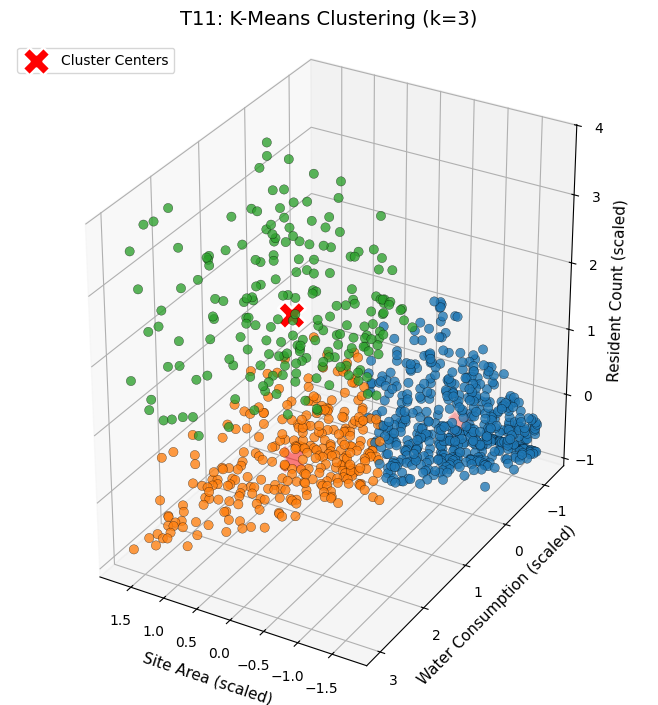

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --- Load & preprocess ---
df = pd.read_csv('/content/electricity_cost_dataset.csv')
for c in df.select_dtypes('object'):
    df[c] = LabelEncoder().fit_transform(df[c])

df['cost_category'] = pd.cut(df['electricity cost'], 3, labels=['Low','Medium','High'])
df = df.dropna(subset=['site area','water consumption','resident count','cost_category'])

X = df[['site area','water consumption','resident count']].values
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# --- K-Means ---
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)
centers = kmeans.cluster_centers_

# --- Random downsample to avoid clutter ---
rng = np.random.RandomState(0)
idx = rng.choice(len(X_scaled), size=min(1000, len(X_scaled)), replace=False)

# --- 3D scatter plot ---
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

# vivid colors per cluster
colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.scatter(X_scaled[idx,0], X_scaled[idx,1], X_scaled[idx,2],
           c=colors[labels[idx]], s=45, alpha=0.78,
           edgecolor='k', linewidth=0.25)

# cluster centers (larger, visible)
ax.scatter(centers[:,0], centers[:,1], centers[:,2],
           c='red', s=400, marker='X', label='Cluster Centers',
           edgecolor='white', linewidth=1.8)

# --- Labels & appearance ---
ax.set_xlabel('Site Area (scaled)', fontsize=11)
ax.set_ylabel('Water Consumption (scaled)', fontsize=11)
ax.set_zlabel('Resident Count (scaled)', fontsize=11)
ax.set_title('T11: K-Means Clustering (k=3)', fontsize=14, pad=12)
ax.legend(loc='upper left')

# New viewing angle for better center visibility
ax.view_init(elev=30, azim=120)   # <-- Adjust this angle for best view
ax.grid(True, alpha=0.3)
r = X_scaled.max(axis=0) - X_scaled.min(axis=0)
ax.set_box_aspect(r / r.max())

plt.tight_layout()
plt.show()


**EVALUATION**


In [ ]:
# ---------------- 4) T12: Cluster Evaluation ----------------
def eval_scores(Xs, labels, name=''):
    sil = silhouette_score(Xs, labels)
    ch  = calinski_harabasz_score(Xs, labels)
    db  = davies_bouldin_score(Xs, labels)
    print(f'{name} -> Silhouette: {sil:.4f}  |  Calinski-Harabasz: {ch:.1f}  |  Davies-Bouldin: {db:.4f}')
    return sil, ch, db

print('T12: Cluster Quality (higher Silhouette & CH are better; lower DB is better)')
eval_scores(Xs, labels_hc, 'Hierarchical (k=3)')
eval_scores(Xs, labels_km, f'K-Means (k={k_opt})')

T12: Cluster Quality (higher Silhouette & CH are better; lower DB is better)
Hierarchical (k=3) -> Silhouette: 0.4061  |  Calinski-Harabasz: 7869.3  |  Davies-Bouldin: 1.0078
K-Means (k=3) -> Silhouette: 0.4350  |  Calinski-Harabasz: 9308.9  |  Davies-Bouldin: 0.9387


(np.float64(0.4350185782158068),
 np.float64(9308.947007613373),
 np.float64(0.9386828294795687))


**tutorials unit 5**

**decision trees**


Accuracy: 0.8015

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.43      0.48       171
           1       0.83      0.89      0.86       828
           2       0.81      0.79      0.80      1001

    accuracy                           0.80      2000
   macro avg       0.73      0.70      0.71      2000
weighted avg       0.80      0.80      0.80      2000



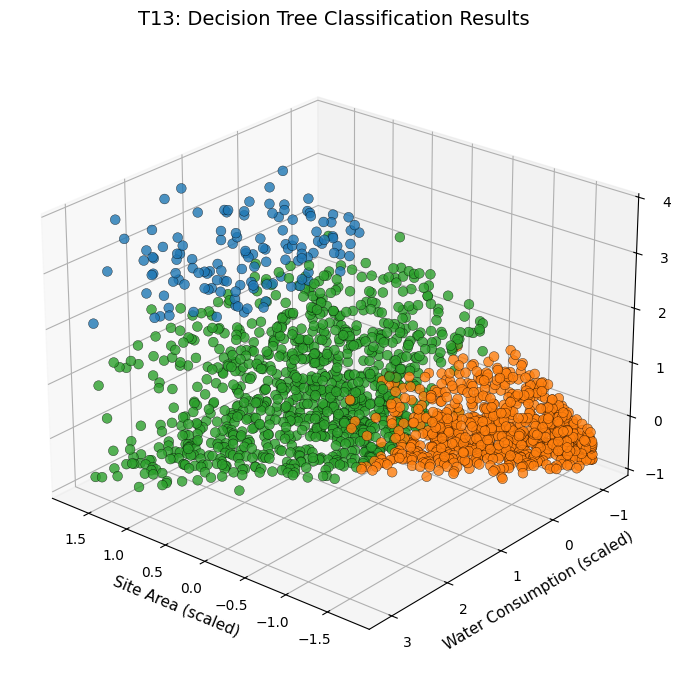

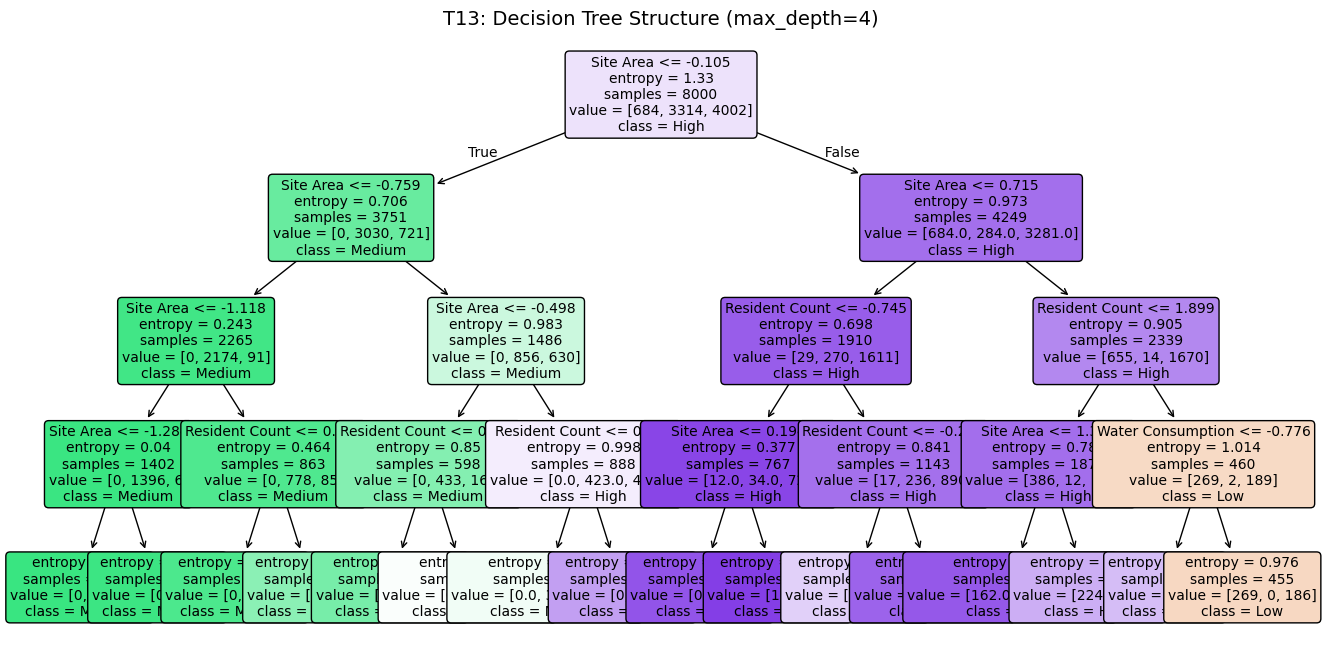

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --- Load and preprocess ---
df = pd.read_csv('/content/electricity_cost_dataset.csv')

# Encode categorical columns
for c in df.select_dtypes('object'):
    df[c] = LabelEncoder().fit_transform(df[c])

# Create target labels (Low, Medium, High)
df['cost_category'] = pd.cut(df['electricity cost'], 3, labels=['Low','Medium','High'])
df = df.dropna(subset=['site area','water consumption','resident count','cost_category'])

# Features + target
X = df[['site area','water consumption','resident count']].values
y = LabelEncoder().fit_transform(df['cost_category'])

# Split + scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# --- Train Decision Tree ---
dt = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

# --- Evaluation ---
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- 3D Scatter Plot (clear visualization) ---
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.scatter(X_test[:,0], X_test[:,1], X_test[:,2],
           c=colors[y_pred], s=50, alpha=0.8, edgecolor='k', linewidth=0.3)

ax.set_xlabel('Site Area (scaled)', fontsize=11)
ax.set_ylabel('Water Consumption (scaled)', fontsize=11)
ax.set_zlabel('Resident Count (scaled)', fontsize=11)
ax.set_title('T13: Decision Tree Classification Results', fontsize=14)
ax.view_init(elev=25, azim=130)  # adjust angle for visibility
plt.tight_layout()
plt.show()

# --- Clear Decision Tree Diagram ---
plt.figure(figsize=(16,8))
plot_tree(
    dt,
    filled=True,
    rounded=True,
    fontsize=10,
    feature_names=['Site Area', 'Water Consumption', 'Resident Count'],
    class_names=['Low','Medium','High']
)
plt.title('T13: Decision Tree Structure (max_depth=4)', fontsize=14)
plt.show()


Accuracy: 0.7865
              precision    recall  f1-score   support

           0       0.44      0.87      0.59       171
           1       0.87      0.86      0.87       828
           2       0.84      0.71      0.77      1001

    accuracy                           0.79      2000
   macro avg       0.72      0.81      0.74      2000
weighted avg       0.82      0.79      0.79      2000



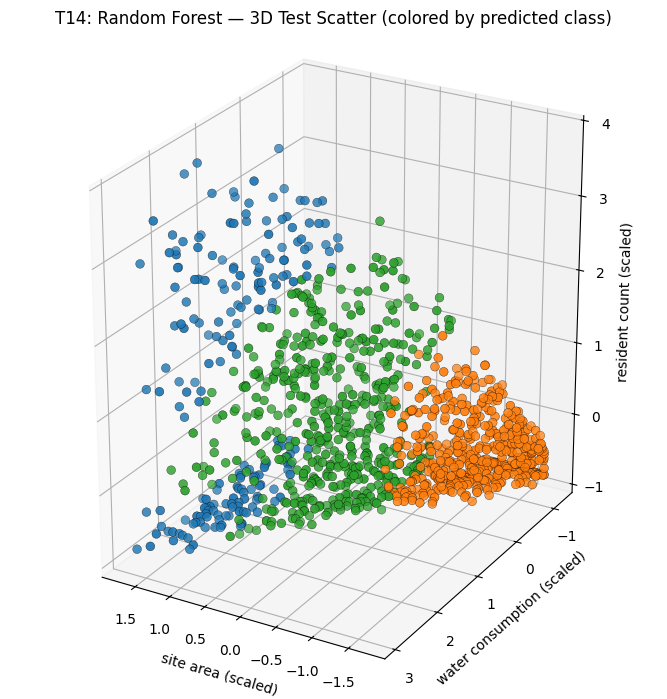

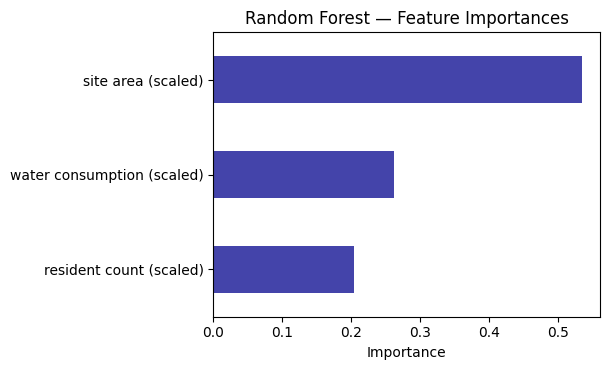

In [ ]:
# T14: Random Forest — clear 3D scatter + feature importances

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Load & preprocess ---
df = pd.read_csv('/content/electricity_cost_dataset.csv')
for c in df.select_dtypes('object'): df[c] = LabelEncoder().fit_transform(df[c])
df['cost_category'] = pd.cut(df['electricity cost'], 3, labels=['Low','Medium','High'])
df = df.dropna(subset=['site area','water consumption','resident count','cost_category'])

FEATS = ['site area','water consumption','resident count']
X = df[FEATS].to_numpy(float)
y = LabelEncoder().fit_transform(df['cost_category'])

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
sc = StandardScaler(); Xtr = sc.fit_transform(Xtr); Xte = sc.transform(Xte)

# --- Train RF ---
rf = RandomForestClassifier(
    n_estimators=200, max_depth=6, min_samples_leaf=3,
    random_state=42, n_jobs=-1, class_weight='balanced_subsample'
).fit(Xtr, ytr)

yp = rf.predict(Xte)
proba = rf.predict_proba(Xte).max(axis=1)  # confidence for alpha sizing

print(f"Accuracy: {accuracy_score(yte, yp):.4f}")
print(classification_report(yte, yp, zero_division=0))

# --- 3D Scatter (low clutter, confidence alpha) ---
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
rng = np.random.RandomState(0)
idx = rng.choice(len(Xte), size=min(1200, len(Xte)), replace=False)

colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c'])
alphas = 0.45 + 0.5*proba[idx]  # 0.45–0.95 transparency by confidence

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xte[idx,0], Xte[idx,1], Xte[idx,2],
           c=colors[yp[idx]], s=40, alpha=alphas, edgecolor='k', linewidth=0.25)
ax.set_xlabel(f'{FEATS[0]} (scaled)'); ax.set_ylabel(f'{FEATS[1]} (scaled)'); ax.set_zlabel(f'{FEATS[2]} (scaled)')
ax.set_title('T14: Random Forest — 3D Test Scatter (colored by predicted class)')
ax.view_init(elev=25, azim=120)
r = Xte.max(0) - Xte.min(0); ax.set_box_aspect(r/r.max()); plt.tight_layout(); plt.show()

# --- Feature Importances (clear) ---
imp = pd.Series(rf.feature_importances_, index=[f'{f} (scaled)' for f in FEATS]).sort_values()
plt.figure(figsize=(6.2,3.8))
imp.plot(kind='barh', color='#4444aa')
plt.title('Random Forest — Feature Importances'); plt.xlabel('Importance'); plt.tight_layout(); plt.show()


Accuracy: 0.8200
              precision    recall  f1-score   support

           0       0.65      0.42      0.51       171
           1       0.90      0.83      0.86       828
           2       0.78      0.88      0.83      1001

    accuracy                           0.82      2000
   macro avg       0.78      0.71      0.73      2000
weighted avg       0.82      0.82      0.82      2000



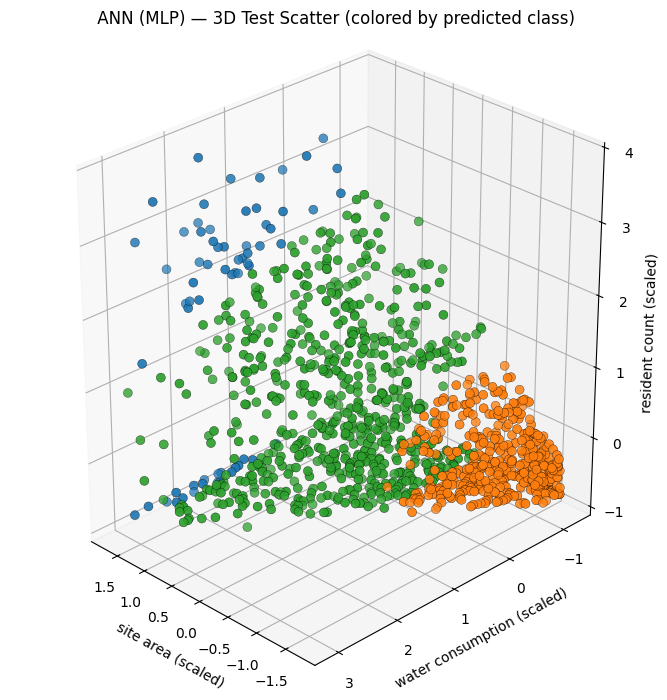

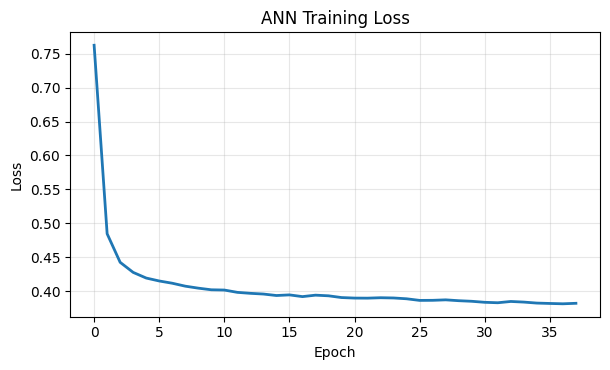

In [ ]:
# T15: Artificial Neural Network (MLP) — clear 3D scatter + training loss

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- Load & preprocess ---
df = pd.read_csv('/content/electricity_cost_dataset.csv')
for c in df.select_dtypes('object'): df[c] = LabelEncoder().fit_transform(df[c])
df['cost_category'] = pd.cut(df['electricity cost'], 3, labels=['Low','Medium','High'])
df = df.dropna(subset=['site area','water consumption','resident count','cost_category'])

FEATS = ['site area','water consumption','resident count']
X = df[FEATS].to_numpy(float)
y = LabelEncoder().fit_transform(df['cost_category'])

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
sc = StandardScaler(); Xtr = sc.fit_transform(Xtr); Xte = sc.transform(Xte)

# --- Train MLP (stable, not too big) ---
mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='relu', solver='adam',
    learning_rate_init=0.003, alpha=1e-4,
    max_iter=500, random_state=42, early_stopping=True, n_iter_no_change=20, validation_fraction=0.15
).fit(Xtr, ytr)

yp = mlp.predict(Xte)
proba = mlp.predict_proba(Xte).max(axis=1)

print(f"Accuracy: {accuracy_score(yte, yp):.4f}")
print(classification_report(yte, yp, zero_division=0))

# --- 3D Scatter (confidence alpha) ---
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
rng = np.random.RandomState(1)
idx = rng.choice(len(Xte), size=min(1200, len(Xte)), replace=False)

colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c'])
alphas = 0.45 + 0.5*proba[idx]

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xte[idx,0], Xte[idx,1], Xte[idx,2],
           c=colors[yp[idx]], s=42, alpha=alphas, edgecolor='k', linewidth=0.25)
ax.set_xlabel(f'{FEATS[0]} (scaled)'); ax.set_ylabel(f'{FEATS[1]} (scaled)'); ax.set_zlabel(f'{FEATS[2]} (scaled)')
ax.set_title(' ANN (MLP) — 3D Test Scatter (colored by predicted class)')
ax.view_init(elev=28, azim=135)
r = Xte.max(0) - Xte.min(0); ax.set_box_aspect(r/r.max()); plt.tight_layout(); plt.show()

# --- Training Loss Curve (for report clarity) ---
plt.figure(figsize=(6.2,3.8))
plt.plot(mlp.loss_curve_, lw=2)
plt.title('ANN Training Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()
